In [6]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import load_diabetes
from keras.layers import Input, Dense

import keras
from keras import Model
from keras import optimizers, losses, metrics
import kdm

In [7]:
# Configuración inicial
os.environ["KERAS_BACKEND"] = "torch"

# Cargar el dataset de Diabetes
X, y = load_diabetes(return_X_y=True)
y = y.astype(float).reshape(-1, 1)


In [8]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamiento de características
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = MinMaxScaler((0.2, 0.8))
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


In [34]:
# Modelo KDM con Gaussian Processes
encoded_size = 10  # Ajustar según experimentos
dim_y = 1
n_comp = 50

In [36]:
kdm_model = kdm.models.KDMRegressModel(
    encoded_size=encoded_size,
    dim_y=dim_y,
    encoder=keras.layers.Identity(),
    n_comp=n_comp,
    sigma=0.1
)

In [37]:
# Compilar modelo
kdm_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=losses.mean_squared_error,
    metrics=[metrics.mean_squared_error]
)

In [38]:
# Inicializar componentes
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
kdm_model.init_components(X_train[indices], y_train[indices], init_sigma=True)


In [39]:
# Entrenamiento del modelo
history = kdm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0147 - val_mean_squared_error: 0.0147
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0132 - val_mean_squared_error: 0.0132
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0120 - val_mean_squared_e

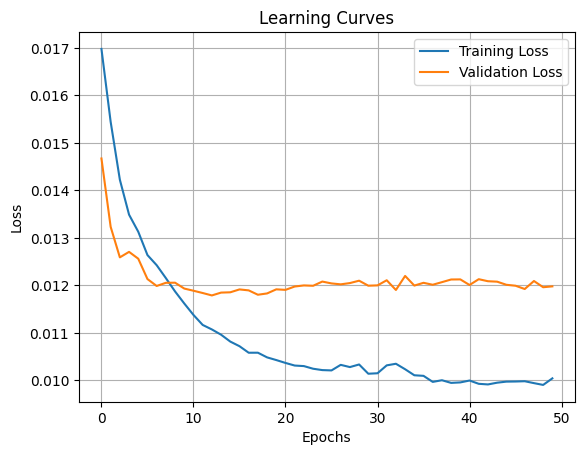

In [40]:
# Graficar la pérdida durante el entrenamiento
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Evaluación en el conjunto de prueba
y_pred = kdm_model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test R^2: {r2}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test MSE: 2725.754764684915
Test MAE: 41.20673875163372
Test R^2: 0.4950723662089501


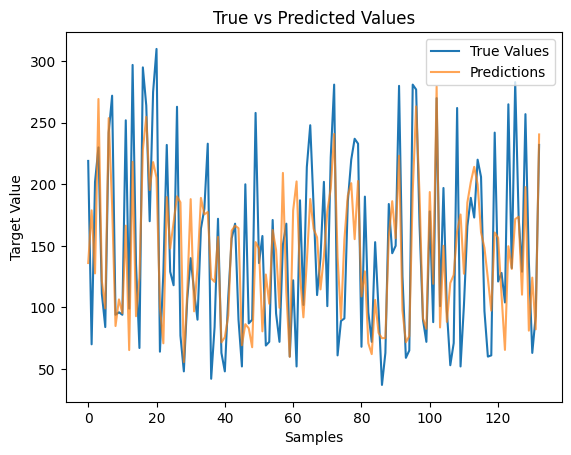

In [42]:
# Visualización de resultados
plt.figure()
plt.plot(y_test_rescaled, label='True Values')
plt.plot(y_pred_rescaled, label='Predictions', alpha=0.7)
plt.title('True vs Predicted Values')
plt.xlabel('Samples')
plt.ylabel('Target Value')
plt.legend()
plt.show()
